In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

## Read data

In [3]:
df_train = pd.read_parquet('train.parquet')
df_train

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


### Create features from id, datetime, values and labels

In [95]:
def createTimeSeriesFeatures(df):
    rows = []
    
    for _, row in df.iterrows():
        dates = row['dates']
        values = row['values']
        label = row['label']
        
        combined = list(zip(dates, values))
        
        for date, value in combined:
            rows.append({
                'id': row['id'],
                'date': date,
                'value': value,
                'label': label
            })
    
    long_df = pd.DataFrame(rows)
    
    long_df['date'] = pd.to_datetime(long_df['date'])

    long_df['year'] = long_df['date'].dt.year
    long_df['month'] = long_df['date'].dt.month
    long_df['day'] = long_df['date'].dt.day
    long_df['day_of_week'] = long_df['date'].dt.dayofweek

    return long_df

In [66]:
features_df = createTimeSeriesFeatures(df_train)

features_df

,id,date,value,label,year,month,day,day_of_week
0,19114,2016-01-01,-1.86000,0.0,2016,1,1,4
1,19114,2016-02-01,0.79000,0.0,2016,2,1,0
2,19114,2016-03-01,1.40000,0.0,2016,3,1,1
3,19114,2016-04-01,0.15000,0.0,2016,4,1,4
4,19114,2016-05-01,0.00000,0.0,2016,5,1,6
...,...,...,...,...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0,2019,11,1,4
5155408,98870,2019-12-01,0.26335,1.0,2019,12,1,6
5155409,98870,2020-01-01,-1.73665,1.0,2020,1,1,2
5155410,98870,2020-02-01,-0.38665,1.0,2020,2,1,5


#### Check for nulls

In [68]:
features_df.isnull().sum()

id                0
date              0
value          4582
label             0
year              0
month             0
day               0
day_of_week       0
dtype: int64

In [69]:
mean_value = features_df['value'].mean()
features_df.fillna(mean_value, inplace=True)
features_df

,id,date,value,label,year,month,day,day_of_week
0,19114,2016-01-01,-1.86000,0.0,2016,1,1,4
1,19114,2016-02-01,0.79000,0.0,2016,2,1,0
2,19114,2016-03-01,1.40000,0.0,2016,3,1,1
3,19114,2016-04-01,0.15000,0.0,2016,4,1,4
4,19114,2016-05-01,0.00000,0.0,2016,5,1,6
...,...,...,...,...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0,2019,11,1,4
5155408,98870,2019-12-01,0.26335,1.0,2019,12,1,6
5155409,98870,2020-01-01,-1.73665,1.0,2020,1,1,2
5155410,98870,2020-02-01,-0.38665,1.0,2020,2,1,5


In [70]:
features_df.isnull().sum()

id             0
date           0
value          0
label          0
year           0
month          0
day            0
day_of_week    0
dtype: int64

In [71]:
features_df.info, features_df.shape

(<bound method DataFrame.info of             id       date    value  label  year  month  day  day_of_week
 0        19114 2016-01-01 -1.86000    0.0  2016      1    1            4
 1        19114 2016-02-01  0.79000    0.0  2016      2    1            0
 2        19114 2016-03-01  1.40000    0.0  2016      3    1            1
 3        19114 2016-04-01  0.15000    0.0  2016      4    1            4
 4        19114 2016-05-01  0.00000    0.0  2016      5    1            6
 ...        ...        ...      ...    ...   ...    ...  ...          ...
 5155407  98870 2019-11-01  1.40335    1.0  2019     11    1            4
 5155408  98870 2019-12-01  0.26335    1.0  2019     12    1            6
 5155409  98870 2020-01-01 -1.73665    1.0  2020      1    1            2
 5155410  98870 2020-02-01 -0.38665    1.0  2020      2    1            5
 5155411  98870 2020-03-01 -1.72665    1.0  2020      3    1            6
 
 [5155412 rows x 8 columns]>,
 (5155412, 8))

In [72]:
features_df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,5155412.0,50108.527821,0.0,25105.75,50149.0,75067.0,99999.0,28865.001711
date,5155412,2019-03-08 08:15:07.744793856,2016-01-01 00:00:00,2017-09-01 00:00:00,2019-02-01 00:00:00,2020-07-01 00:00:00,2024-01-01 00:00:00,NaN
value,5155412.0,-0.029833,-7.95,-0.84,-0.12,0.76,9.54,1.22424
label,5155412.0,0.273854,0.0,0.0,0.0,1.0,1.0,0.445935
year,5155412.0,2018.734503,2016.0,2017.0,2019.0,2020.0,2024.0,1.862358
month,5155412.0,6.38347,1.0,3.0,6.0,9.0,12.0,3.443433
day,5155412.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
day_of_week,5155412.0,3.018144,0.0,1.0,3.0,5.0,6.0,1.983396


## EDA

Classes distribution based on label

<Axes: xlabel='label'>

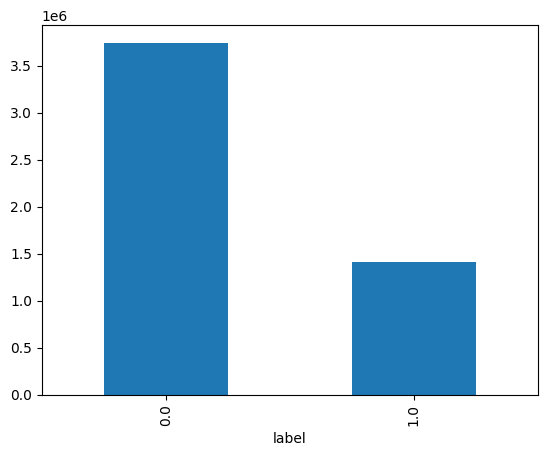

In [73]:
features_df['label'].value_counts().plot(kind='bar')

Statistics for values for classes

In [74]:
features_df['value'].apply(lambda x: pd.Series(x)).describe()

,0
count,5.155412e+06
mean,-2.983263e-02
std,1.224240e+00
min,-7.950000e+00
25%,-8.400000e-01
50%,-1.200000e-01
75%,7.600000e-01
max,9.540000e+00


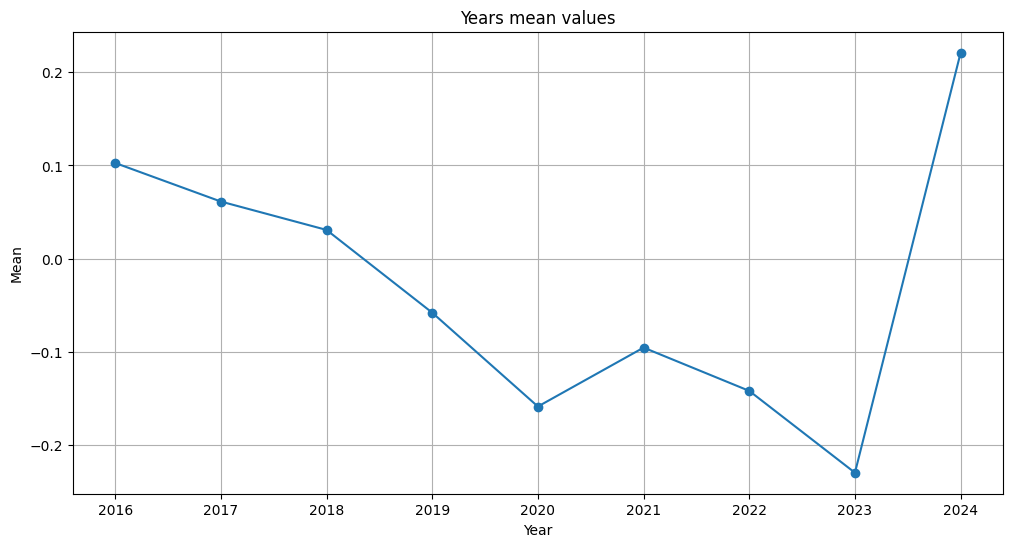

In [75]:
yearly_avg = features_df.groupby('year')['value'].mean()

plt.figure(figsize=(12, 6))

plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title('Years mean values')
plt.xlabel('Year')
plt.ylabel('Mean')
plt.grid()
plt.xticks(yearly_avg.index)
plt.show()

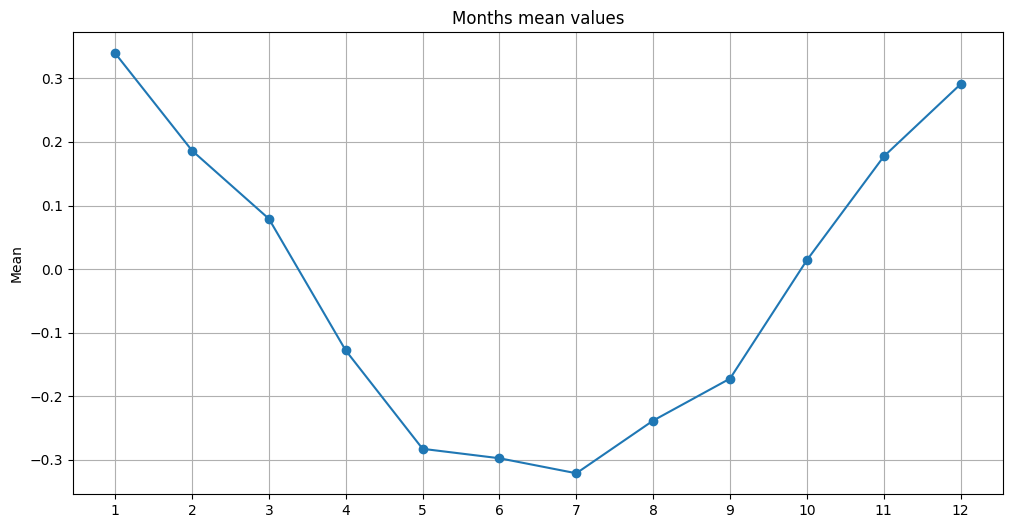

In [76]:
monthly_avg = features_df.groupby('month')['value'].mean()

plt.figure(figsize=(12, 6))

plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Months mean values')
plt.ylabel('Mean')
plt.grid()
plt.xticks(monthly_avg.index)
plt.show()

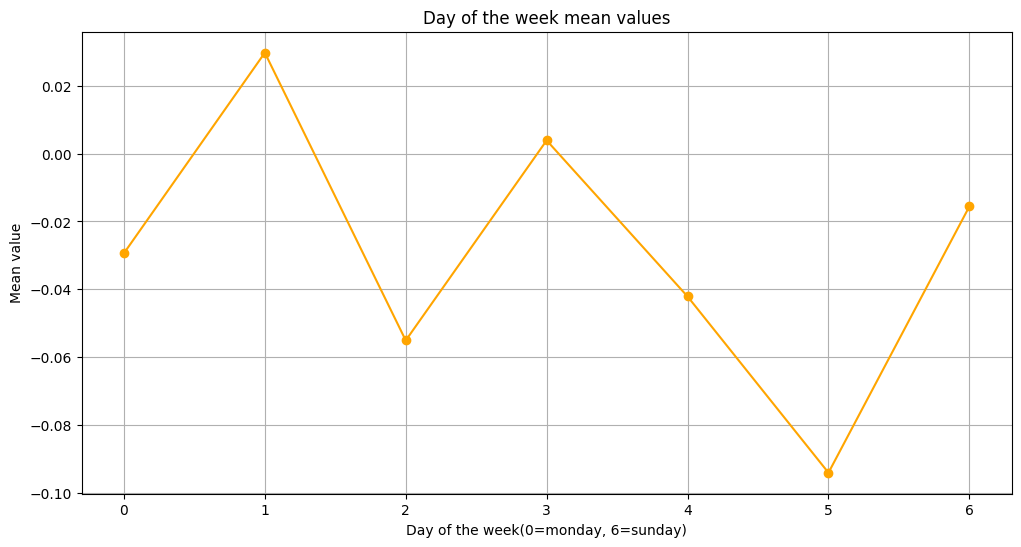

In [94]:
weekly_avg = features_df.groupby('day_of_week')['value'].mean()

plt.figure(figsize=(12, 6))

plt.plot(weekly_avg.index, weekly_avg.values, marker='o', color='orange')
plt.title('Day of the week mean values')
plt.xlabel('Day of the week(0=monday, 6=sunday)')
plt.ylabel('Mean value')
plt.grid()
plt.xticks(weekly_avg.index)
plt.show()

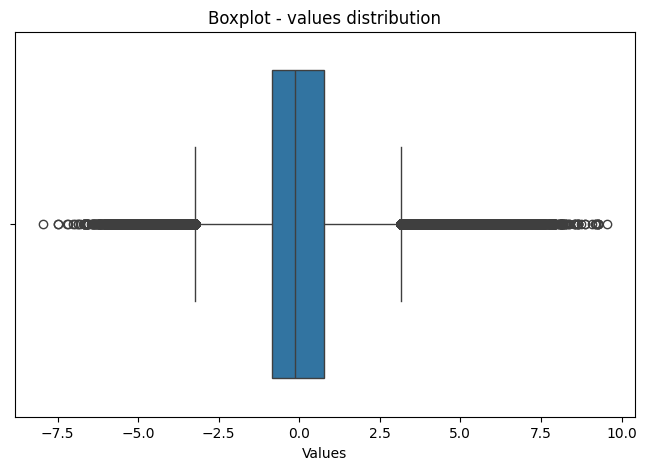

In [78]:
plt.figure(figsize=(8,5))
sns.boxplot(data=features_df, x='value')
plt.xlabel('Values')
plt.title(f'Boxplot - values distribution');

## Classification with catboost